# Model Haar interferometer with squeezed states, with training on particle number

We test the boson sampling operator 
on coherent states and squeezed states, and 
propagating in a random medium

We train the random medium to maximize the sum of photons in modes 0 and 1, 
as n0+n1

nonlinearxwaves@gmail.com<br>
@created 28 january 2021 <br>
@version 4 may 2023<br>

In [1]:
import numpy as np
from thqml import phasespace as ps
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import itertools as it

2023-05-04 05:55:06.715800: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-04 05:55:06.715821: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

In [3]:
tf.keras.backend.clear_session()

In [4]:
np.set_printoptions(precision=4)

Check GPU

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


2023-05-04 05:55:14.488273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-04 05:55:14.488308: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-04 05:55:14.488346: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist


In [11]:
# do not display warnings
import warnings
warnings.filterwarnings('ignore')

## Dimension

In [12]:
N = 12

In [13]:
n=np.floor_divide(N,2)

In [14]:
nmodes = int(n)

In [15]:
print('Number of modes '+repr(n))

Number of modes 6


## Build vacuum by the Gaussian state

In [16]:
vacuum = ps.VacuumLayer(N)

2023-05-04 05:55:38.156597: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Parameter for squeezing

In [17]:
r_np=0.88;
theta_np=np.pi/4;

## Random medium (Haar measure)

In [18]:
HAAR=ps.HaarLayerConstant(N)

In [19]:
R=ps.RandomLayer(N) # trainable layer

## Displacer

In [20]:
D=ps.DisplacementLayerConstant(np.ones((N,1)))

## Build the model (the squeezed states are not trainable)
squeezed states are generated and mixed by a random medium and then go into an Haar Inteferometer

In [28]:
xin = tf.keras.layers.Input(N)
x1, a1 = HAAR(xin)
x1, a1 = R(x1,a1)
for j in range(nmodes):
    x1, a1 = ps.SingleModeSqueezerLayer(N, r_np=r_np, theta_np=theta_np, n_squeezed=j, trainable=False)(x1,a1)
x1, a1=D(x1,a1)    
chir, chii = vacuum(x1, a1)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

In [29]:
model.input_shape[1]

12

In [30]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 haar_layer_constant (HaarLayer  [(None, 12),        0           ['input_2[0][0]']                
 Constant)                       (12, 1)]                                                         
                                                                                                  
 random_layer (RandomLayer)     [(None, 12),         72          ['haar_layer_constant[1][0]',    
                                 (12, 1)]                         'haar_layer_constant[1][1]']    
                                                                                            

The model has 72 parameters, corresponding to the 6x6 matrices WR and WI of the random layer, however not all parameters are used as the output matrix is complex unitary and has 2x6x6-36=36 parameters

## Photon counter layer 

Dummy input

In [31]:
Nbatch=10
xtrain = np.random.rand(Nbatch, N)-0.5

Model with the photon counting layer

In [33]:
%%time
photon_counter=ps.PhotonCountingLayer(N) # define the layer
n_out = photon_counter(chir,chir, model);  # define the output tensor
Nphoton = tf.keras.Model(inputs = xin, outputs=n_out) # define the model with inputs and ouputs
tf.print(Nphoton(xtrain)); 

[[2.48752522 1.79012394 3.48116684 1.57034874 1.4351027 1.20082355]]
CPU times: user 1.86 s, sys: 24.7 ms, total: 1.88 s
Wall time: 1.88 s


Print the current values for the mean photon number per mode

In [34]:
Nphoton.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 haar_layer_constant (HaarLayer  [(None, 12),        0           ['input_2[0][0]']                
 Constant)                       (12, 1)]                                                         
                                                                                                  
 random_layer (RandomLayer)     [(None, 12),         72          ['haar_layer_constant[1][0]',    
                                 (12, 1)]                         'haar_layer_constant[1][1]']    
                                                                                            

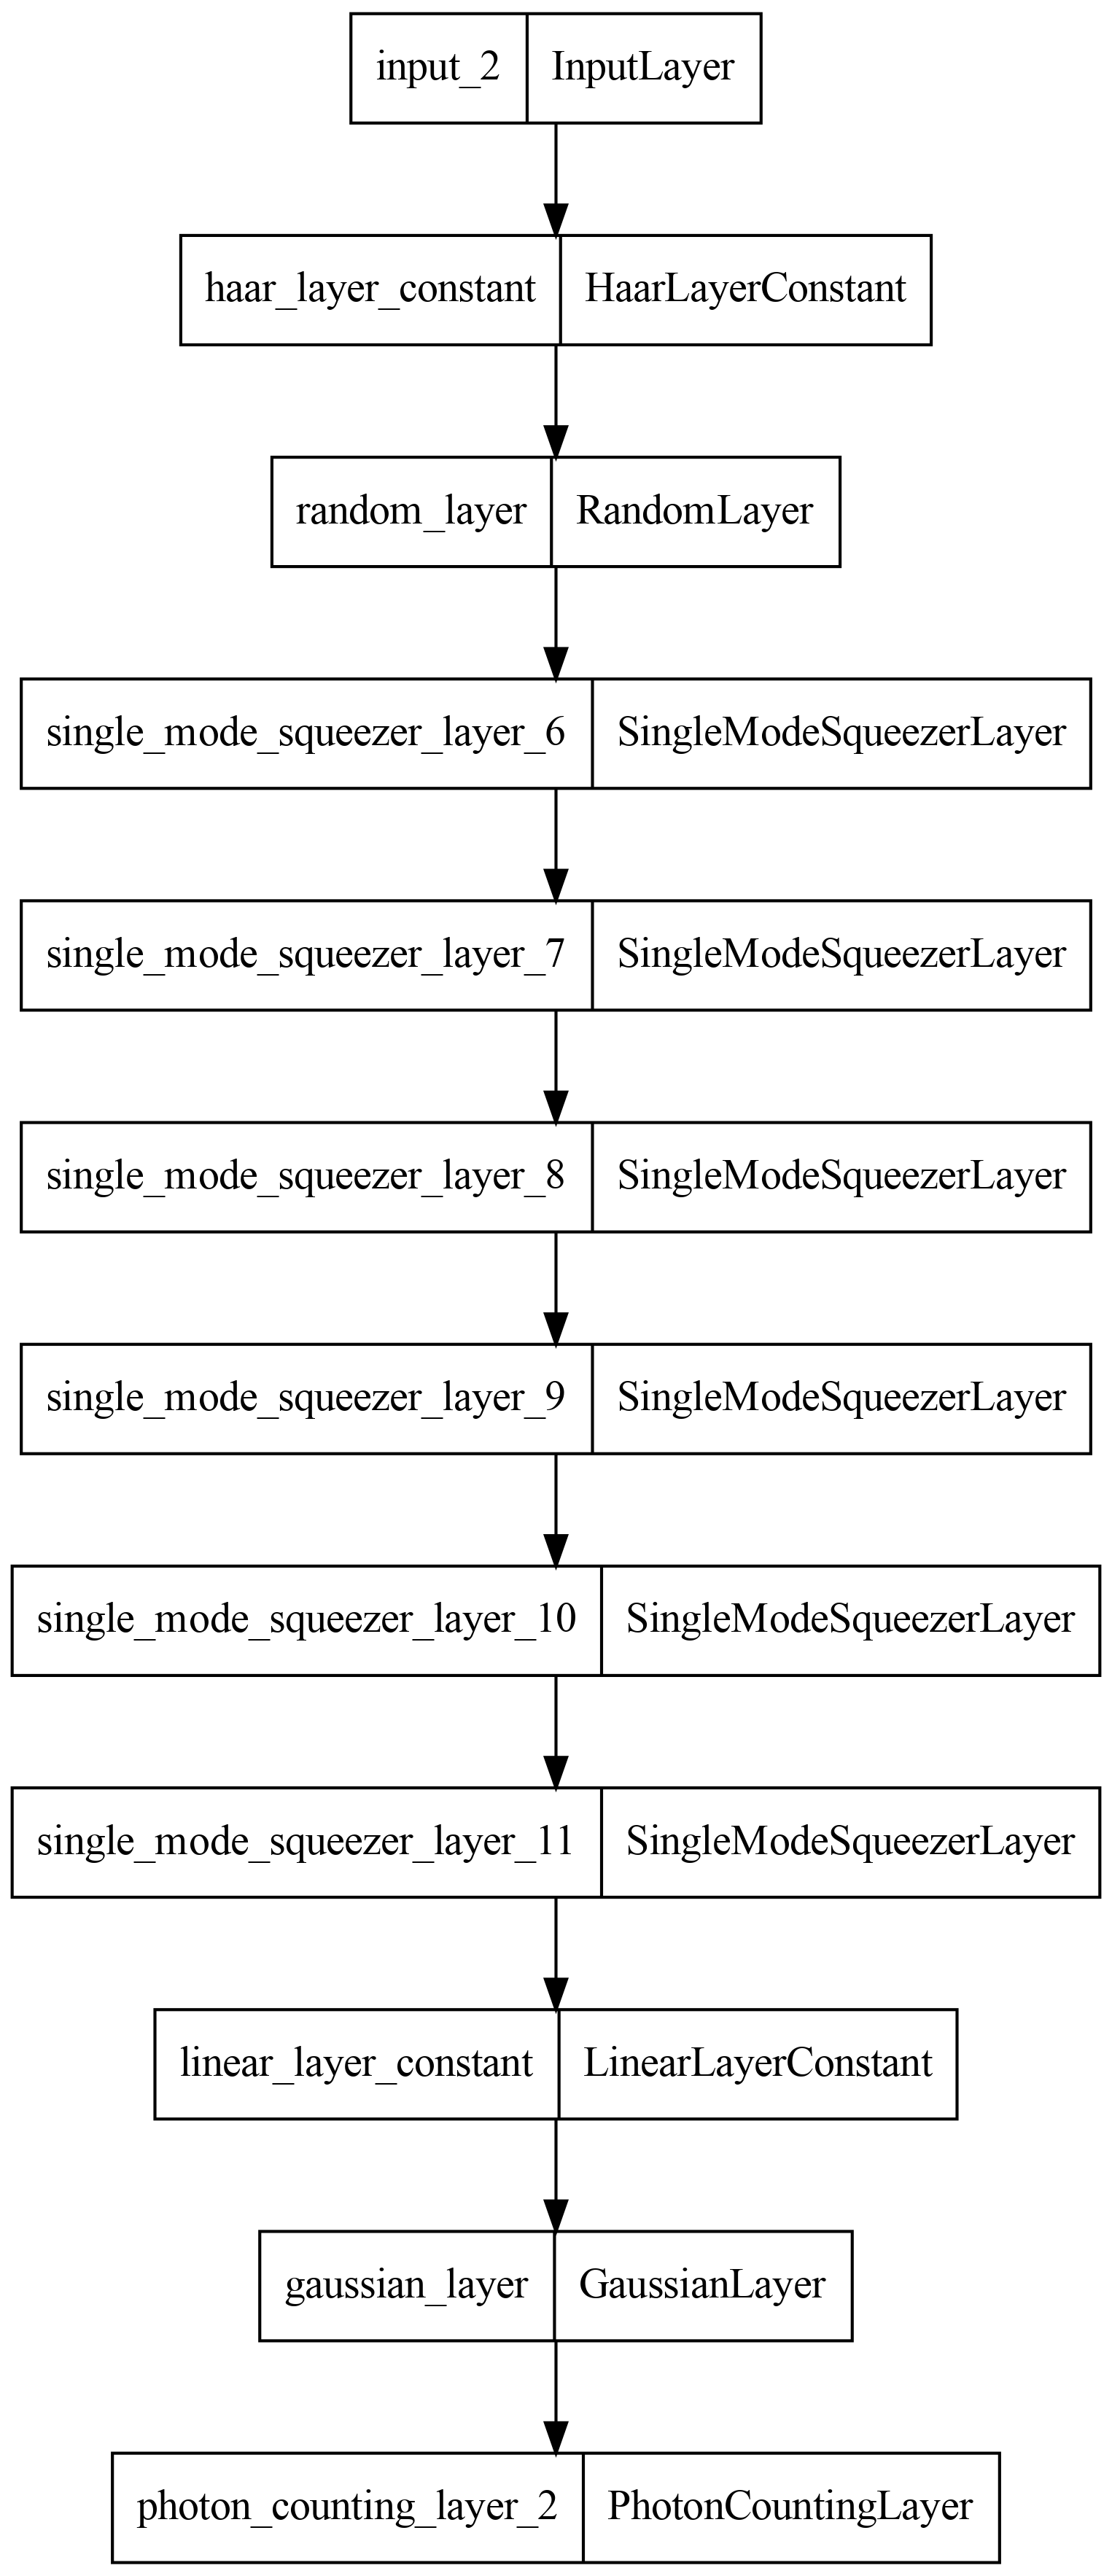

In [35]:
tf.keras.utils.plot_model(
    Nphoton, to_file='modelBS7.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=300,
    layer_range=None, show_layer_activations=False
)

In [37]:
# Plot the model in a pdf file
tf.keras.utils.plot_model(
    Nphoton, to_file='modelBS7.pdf', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=300,
    layer_range=None, show_layer_activations=False
)

## Model with the target output to train

Model with the custom ouput to train

In [38]:
n_out0=tf.gather(tf.squeeze(n_out),0) 
n_out1=tf.gather(tf.squeeze(n_out),1)
min_out=tf.exp(-n_out0-n_out1)
Train_model = tf.keras.Model(inputs = xin, outputs=min_out) # define the model with inputs and ouputs

Add loss to the model as the value of the min_out tensor

In [39]:
Train_model.add_loss(min_out)
Train_model.compile(optimizer='Adam')

Alternative method : Define the custom loss to train the model for maximum output

In [40]:
#def custom_loss(yt,yp):
    # the loss only return the output of the network yp
    # that need to be minimized
#    return yp
#Train_model.compile(loss=custom_loss, optimizer='Adam')

# Transform model

In [41]:
kin, Qrho =ps.getQTransformModel(model)

In [42]:
Qrho.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12)]              0         
                                                                 
 q_transform_layer (QTransfo  (None, None)             240       
 rmLayer)                                                        
                                                                 
Total params: 240
Trainable params: 72
Non-trainable params: 168
_________________________________________________________________


Note that the Qrho model summary does not include the previous model but retain the number of trainable parameters

# Test the Pr operator 

Probability of zero photon

In [43]:
%%time
ps.Pr([0]*nmodes, Qrho)

CPU times: user 9.7 ms, sys: 192 µs, total: 9.9 ms
Wall time: 9 ms


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0062]], dtype=float32)>

Probability of two photons

In [44]:
%time
nbar = [0]*nmodes
nbar[0]=2
print(nbar)
tf.print(ps.Pr(nbar, Qrho))

CPU times: user 11 µs, sys: 1e+03 ns, total: 12 µs
Wall time: 24.1 µs
[2, 0, 0, 0, 0, 0]
[0.00190656236]


# Generate all the possible photon patterns assuming max one photon per mode

In [45]:
def patterns(nphotons, nmodes):
    # Return the patterns of nmodes with maximal nphotons
    
    # generate a list of zero
    l1=[0]*nmodes
    # set nphotons 1
    for j in range(nphotons):
        l1[j]=1
    # compute all the permutations (zeros and one are distinguishable)
    nlist=it.permutations(l1,nmodes) # return iterators
    # convert to list the iterators
    ln=list(nlist)
    # sort the list in reverse order to have the patterns with more ones first
    ln.sort(reverse=True)
    # remove duplicates (remove adjactent identical elements after sorting)
    ln=list(ln for ln,_ in it.groupby(ln))
    return ln

In [46]:
%%time
ln =patterns(2,nmodes)
print(ln)
print(len(ln))

[(1, 1, 0, 0, 0, 0), (1, 0, 1, 0, 0, 0), (1, 0, 0, 1, 0, 0), (1, 0, 0, 0, 1, 0), (1, 0, 0, 0, 0, 1), (0, 1, 1, 0, 0, 0), (0, 1, 0, 1, 0, 0), (0, 1, 0, 0, 1, 0), (0, 1, 0, 0, 0, 1), (0, 0, 1, 1, 0, 0), (0, 0, 1, 0, 1, 0), (0, 0, 1, 0, 0, 1), (0, 0, 0, 1, 1, 0), (0, 0, 0, 1, 0, 1), (0, 0, 0, 0, 1, 1)]
15
CPU times: user 625 µs, sys: 0 ns, total: 625 µs
Wall time: 616 µs


## Make a plot versus the probability

Build an array of photon number sampling

In [47]:
%%time
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

Sample 0 of 15 (1, 1, 0, 0, 0, 0)
0.001103726
Sample 1 of 15 (1, 0, 1, 0, 0, 0)
0.0017488812
Sample 2 of 15 (1, 0, 0, 1, 0, 0)
0.0019296694
Sample 3 of 15 (1, 0, 0, 0, 1, 0)
0.0037327656
Sample 4 of 15 (1, 0, 0, 0, 0, 1)
0.00016313116
Sample 5 of 15 (0, 1, 1, 0, 0, 0)
0.004468744
Sample 6 of 15 (0, 1, 0, 1, 0, 0)
0.0009861799
Sample 7 of 15 (0, 1, 0, 0, 1, 0)
0.00013324735
Sample 8 of 15 (0, 1, 0, 0, 0, 1)
0.0010923457
Sample 9 of 15 (0, 0, 1, 1, 0, 0)
0.002043529
Sample 10 of 15 (0, 0, 1, 0, 1, 0)
0.00073620153
Sample 11 of 15 (0, 0, 1, 0, 0, 1)
0.0010144892
Sample 12 of 15 (0, 0, 0, 1, 1, 0)
0.0006511268
Sample 13 of 15 (0, 0, 0, 1, 0, 1)
0.00061656174
Sample 14 of 15 (0, 0, 0, 0, 1, 1)
1.2694654e-05
Done
CPU times: user 938 ms, sys: 6.79 ms, total: 945 ms
Wall time: 939 ms


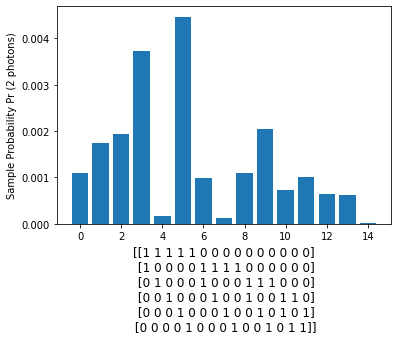

In [49]:
plt.bar(range(npatterns),Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr (2 photons)');
# save figure in pdf
plt.savefig('BS7pairsnotraining.pdf', 
            format='pdf', bbox_inches='tight')


## Patterns with 4 photons

In [50]:
%%time
ln =patterns(4,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar+1)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')


15
Sample 1 of 15 (1, 1, 1, 1, 0, 0)
0.00026280183
Sample 2 of 15 (1, 1, 1, 0, 1, 0)
0.0014220187
Sample 3 of 15 (1, 1, 1, 0, 0, 1)
0.0001965583
Sample 4 of 15 (1, 1, 0, 1, 1, 0)
0.00020338253
Sample 5 of 15 (1, 1, 0, 1, 0, 1)
0.00034394115
Sample 6 of 15 (1, 1, 0, 0, 1, 1)
0.0002557302
Sample 7 of 15 (1, 0, 1, 1, 1, 0)
0.0011973797
Sample 8 of 15 (1, 0, 1, 1, 0, 1)
0.00032104104
Sample 9 of 15 (1, 0, 1, 0, 1, 1)
0.0007619789
Sample 10 of 15 (1, 0, 0, 1, 1, 1)
0.0002022206
Sample 11 of 15 (0, 1, 1, 1, 1, 0)
0.00026766787
Sample 12 of 15 (0, 1, 1, 1, 0, 1)
0.0011314221
Sample 13 of 15 (0, 1, 1, 0, 1, 1)
2.3508655e-06
Sample 14 of 15 (0, 1, 0, 1, 1, 1)
5.623051e-05
Sample 15 of 15 (0, 0, 1, 1, 1, 1)
0.000109705354
Done
CPU times: user 26.6 s, sys: 4.62 ms, total: 26.6 s
Wall time: 26.6 s


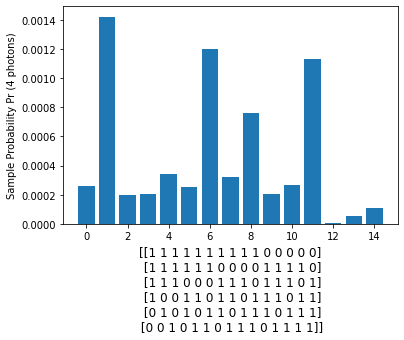

In [51]:
plt.bar(range(npatterns),Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr (4 photons)');
plt.savefig('BS7quaternotraining.pdf', 
            format='pdf',bbox_inches='tight')

## Compute the probability of pairs 

In [52]:
%%time
nmax = 2 # number of couples
probn=np.zeros([nmax+1,], dtype=np_real)
for j in range(nmax+1):
    photon_number=2*j
    # generate the patterns
    ln=patterns(photon_number,nmodes)
    npattern=len(ln)
    print('Generated '+repr(npattern)+\
          ' patterns with photon number '+repr(photon_number))
    # compute probability for each pattern
    Pn=np.zeros([npattern,], dtype=np_real)
    for nbar in range(npattern):        
        Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
        print('Photons '+repr(photon_number)+' Sample '+repr(nbar+1)+\
              ' of '+repr(npatterns)+' Pr=' +repr(Pn[nbar])+\
              ' pattern '+repr(ln[nbar]))
    # sum the probability of each pattern
    probn[j]=sum(Pn)
print('Done')

Generated 1 patterns with photon number 0
Photons 0 Sample 1 of 15 Pr=0.006241495721042156 pattern (0, 0, 0, 0, 0, 0)
Generated 15 patterns with photon number 2
Photons 2 Sample 1 of 15 Pr=0.0011037259828299284 pattern (1, 1, 0, 0, 0, 0)
Photons 2 Sample 2 of 15 Pr=0.0017488811863586307 pattern (1, 0, 1, 0, 0, 0)
Photons 2 Sample 3 of 15 Pr=0.0019296694081276655 pattern (1, 0, 0, 1, 0, 0)
Photons 2 Sample 4 of 15 Pr=0.003732765559107065 pattern (1, 0, 0, 0, 1, 0)
Photons 2 Sample 5 of 15 Pr=0.00016313116066157818 pattern (1, 0, 0, 0, 0, 1)
Photons 2 Sample 6 of 15 Pr=0.004468744155019522 pattern (0, 1, 1, 0, 0, 0)
Photons 2 Sample 7 of 15 Pr=0.0009861799189820886 pattern (0, 1, 0, 1, 0, 0)
Photons 2 Sample 8 of 15 Pr=0.000133247347548604 pattern (0, 1, 0, 0, 1, 0)
Photons 2 Sample 9 of 15 Pr=0.0010923456866294146 pattern (0, 1, 0, 0, 0, 1)
Photons 2 Sample 10 of 15 Pr=0.002043528947979212 pattern (0, 0, 1, 1, 0, 0)
Photons 2 Sample 11 of 15 Pr=0.0007362015312537551 pattern (0, 0, 1, 0,

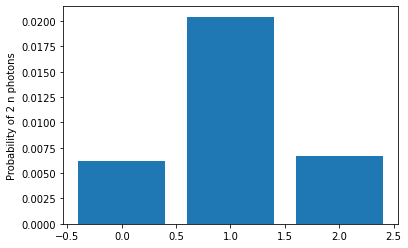

In [53]:
plt.bar(range(nmax+1),probn)
plt.ylabel('Probability of 2 n photons');
plt.savefig('BS7ALLnotraining.pdf',
            format='pdf',bbox_inches='tight') 


# Train the model and recompute probabilities

In [54]:
%%time
history=Train_model.fit(xtrain,np.zeros_like(xtrain),epochs=10000,verbose=0)

Plot training history

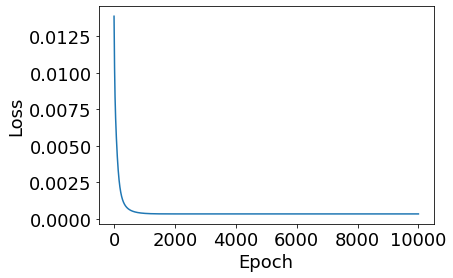

In [55]:
fig =plt.figure()
plt.rcParams.update({'font.size': 18})
ax = fig.add_subplot(1, 1, 1)
ax.plot(history.history['loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.savefig('BS7traininghistory.pdf', 
            format='pdf',bbox_inches='tight') 

## Recompute the transform

In [56]:
kin, Qrho =ps.getQTransformModel(model)

## Patterns with 2 photons

In [57]:
%%time
ln =patterns(2,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

15
Sample 0 of 15 (1, 1, 0, 0, 0, 0)
0.0038629244
Sample 1 of 15 (1, 0, 1, 0, 0, 0)
4.8357993e-05
Sample 2 of 15 (1, 0, 0, 1, 0, 0)
0.000115690986
Sample 3 of 15 (1, 0, 0, 0, 1, 0)
2.4901005e-05
Sample 4 of 15 (1, 0, 0, 0, 0, 1)
1.1635944e-05
Sample 5 of 15 (0, 1, 1, 0, 0, 0)
0.00046740478
Sample 6 of 15 (0, 1, 0, 1, 0, 0)
0.0011182623
Sample 7 of 15 (0, 1, 0, 0, 1, 0)
0.00024067011
Sample 8 of 15 (0, 1, 0, 0, 0, 1)
0.00011247123
Sample 9 of 15 (0, 0, 1, 1, 0, 0)
1.4467609e-05
Sample 10 of 15 (0, 0, 1, 0, 1, 0)
0.00064713357
Sample 11 of 15 (0, 0, 1, 0, 0, 1)
0.0017666329
Sample 12 of 15 (0, 0, 0, 1, 1, 0)
0.00035443206
Sample 13 of 15 (0, 0, 0, 1, 0, 1)
0.00083246146
Sample 14 of 15 (0, 0, 0, 0, 1, 1)
0.00020400312
Done
CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 1 s


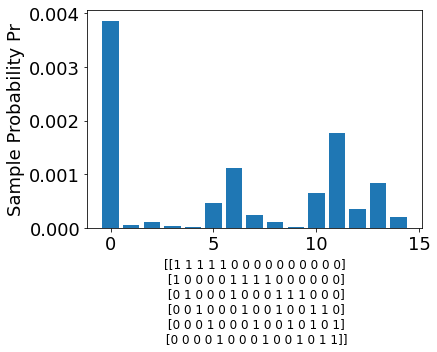

In [58]:
plt.bar(range(npatterns),Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr');
plt.savefig('BS7pairstrained.pdf'
            , format='pdf',bbox_inches='tight') 

## Patterns of 4 photons

In [59]:
%%time
ln =patterns(4,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

15
Sample 0 of 15 (1, 1, 1, 1, 0, 0)
8.7480585e-06
Sample 1 of 15 (1, 1, 1, 0, 1, 0)
0.00035813716
Sample 2 of 15 (1, 1, 1, 0, 0, 1)
0.0011744553
Sample 3 of 15 (1, 1, 0, 1, 1, 0)
0.00031547458
Sample 4 of 15 (1, 1, 0, 1, 0, 1)
0.0004038397
Sample 5 of 15 (1, 1, 0, 0, 1, 1)
0.00014907222
Sample 6 of 15 (1, 0, 1, 1, 1, 0)
2.0056323e-05
Sample 7 of 15 (1, 0, 1, 1, 0, 1)
1.3076671e-05
Sample 8 of 15 (1, 0, 1, 0, 1, 1)
8.775445e-06
Sample 9 of 15 (1, 0, 0, 1, 1, 1)
2.2944296e-06
Sample 10 of 15 (0, 1, 1, 1, 1, 0)
0.00019385686
Sample 11 of 15 (0, 1, 1, 1, 0, 1)
0.00012640227
Sample 12 of 15 (0, 1, 1, 0, 1, 1)
8.4794396e-05
Sample 13 of 15 (0, 1, 0, 1, 1, 1)
2.215988e-05
Sample 14 of 15 (0, 0, 1, 1, 1, 1)
4.2394106e-05
Done
CPU times: user 27 s, sys: 0 ns, total: 27 s
Wall time: 27 s


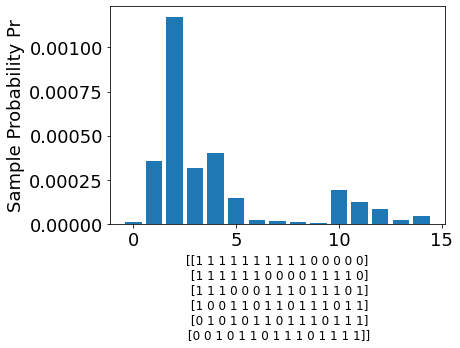

In [60]:
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.bar(range(npatterns),Pn)
plt.ylabel('Sample Probability Pr');
plt.savefig('BS7quatertrained.pdf'
            , format='pdf',bbox_inches='tight') 


# Check the weights of layers

In [61]:
model.layers

In [62]:
tf.print(model.layers[2].get_M())

([[0.653131545 -0.351500064 -0.463044584 ... 0.110635221 0.184998155 0.0851071849]
 [0.351500064 0.653131545 0.0790091902 ... -0.0859148502 -0.0851071849 0.184998155]
 [0.285464942 0.255994141 0.0130427293 ... -0.346586138 0.561951876 0.11625351]
 ...
 [-0.0102206282 0.00151605846 -0.102173209 ... 0.598872244 0.0822414309 -0.226550192]
 [0.0374502391 0.33977437 -0.471867085 ... -0.182918876 -0.219606891 -0.646491528]
 [-0.33977437 0.0374502391 -0.0542856455 ... 0.136695206 0.646491528 -0.219606891]], [[0.653131545 0.351500064 0.285464942 ... -0.0102206282 0.0374502391 -0.33977437]
 [-0.351500064 0.653131545 0.255994141 ... 0.00151605846 0.33977437 0.0374502391]
 [-0.463044584 0.0790091902 0.0130427293 ... -0.102173209 -0.471867085 -0.0542856455]
 ...
 [0.110635221 -0.0859148502 -0.346586138 ... 0.598872244 -0.182918876 0.136695206]
 [0.184998155 -0.0851071849 0.561951876 ... 0.0822414309 -0.219606891 0.646491528]
 [0.0851071849 0.184998155 0.11625351 ... -0.226550192 -0.646491528 -0.21

# Compute the statistical probability of pairs

In [63]:
%%time
nmax = 2 # number of couples
probn=np.zeros([nmax+1,], dtype=np_real)
for j in range(nmax+1):
    photon_number=2*j
    # generate the patterns
    ln=patterns(photon_number,nmodes)
    npattern=len(ln)
    print('Generated '+repr(npattern)+\
          ' patterns with photon number '+repr(photon_number))
    # compute probability for each pattern
    Pn=np.zeros([npattern,], dtype=np_real)
    for nbar in range(npattern):        
        Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
        print('Photons '+repr(photon_number)+' Sample '+repr(nbar+1)+\
              ' of '+repr(npatterns)+' Pr=' +repr(Pn[nbar])+\
              ' pattern '+repr(ln[nbar]))
    # sum the probability of each pattern
    probn[j]=sum(Pn)
print('Done')

Generated 1 patterns with photon number 0
Photons 0 Sample 1 of 15 Pr=0.006241521332412958 pattern (0, 0, 0, 0, 0, 0)
Generated 15 patterns with photon number 2
Photons 2 Sample 1 of 15 Pr=0.0038629244081676006 pattern (1, 1, 0, 0, 0, 0)
Photons 2 Sample 2 of 15 Pr=4.8357993364334106e-05 pattern (1, 0, 1, 0, 0, 0)
Photons 2 Sample 3 of 15 Pr=0.00011569098569452763 pattern (1, 0, 0, 1, 0, 0)
Photons 2 Sample 4 of 15 Pr=2.4901004508137703e-05 pattern (1, 0, 0, 0, 1, 0)
Photons 2 Sample 5 of 15 Pr=1.1635944247245789e-05 pattern (1, 0, 0, 0, 0, 1)
Photons 2 Sample 6 of 15 Pr=0.00046740478137508035 pattern (0, 1, 1, 0, 0, 0)
Photons 2 Sample 7 of 15 Pr=0.0011182622984051704 pattern (0, 1, 0, 1, 0, 0)
Photons 2 Sample 8 of 15 Pr=0.00024067010963335633 pattern (0, 1, 0, 0, 1, 0)
Photons 2 Sample 9 of 15 Pr=0.00011247122893109918 pattern (0, 1, 0, 0, 0, 1)
Photons 2 Sample 10 of 15 Pr=1.4467608707491308e-05 pattern (0, 0, 1, 1, 0, 0)
Photons 2 Sample 11 of 15 Pr=0.0006471335655078292 pattern (

In [64]:
probn

array([0.0062, 0.0098, 0.0029])

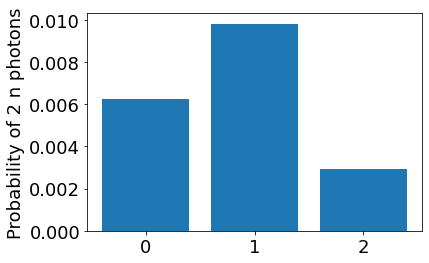

In [65]:
plt.bar(range(nmax+1),probn)
#plt.xlabel(ln, fontsize=6);
plt.ylabel('Probability of 2 n photons');
plt.savefig('BS7ALLtrained.pdf', 
            format='pdf',bbox_inches='tight') 


Looks that the overall probability does not change, but most of the couples appears in the target modes